In [76]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout

In [77]:
df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',', 
                 parse_dates={'dt' : ['Ano', 'Mês', 'Dia']},
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [78]:
#filtra produto 'Alface Crespa - Roça', mantendo a coluna Preco_unitario
filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario']]

#agrupa por semana
filtered_alface_crespa_roca = filtered_alface_crespa_roca.resample('W').mean()

#preenche valores faltantes usando interpolação linear
filtered_alface_crespa_roca = filtered_alface_crespa_roca.interpolate(method='linear')

filtered_alface_crespa_roca.index.tz_localize("UTC").tz_convert("America/Sao_Paulo")

#identifica cada semana
filtered_alface_crespa_roca['week'] = filtered_alface_crespa_roca.index.strftime('%Y-w%V')

#ordena por data
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)
filtered_alface_crespa_roca

,Preco_unitario,week
dt,,
2016-04-24,0.61650,2016-w16
2016-05-01,0.42611,2016-w17
2016-05-08,0.43778,2016-w18
2016-05-15,0.43056,2016-w19
2016-05-22,0.44444,2016-w20
...,...,...
2023-08-27,0.40833,2023-w34
2023-09-03,0.37500,2023-w35
2023-09-10,0.35417,2023-w36


In [79]:
columns = ["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)","PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)","PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)","RADIACAO GLOBAL (Kj/m²)","TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","TEMPERATURA DO PONTO DE ORVALHO (°C)","TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)","TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)","TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)","TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)","UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)","UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)","UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)", "x"]

weather_df_2023 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2023_A_30-09-2023.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2023.columns = columns

weather_df_2022 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2022_A_31-12-2022.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2022.columns = columns

weather_df_2021 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2021_A_31-12-2021.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2021.columns = columns

weather_df_2020 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2020_A_31-12-2020.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2020.columns = columns

weather_df_2019 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2019_A_31-12-2019.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2019.columns = columns

#todo: ver como importar os dados de 2016, 2017 e 2018 (estão em outro formato)

weather_df = pd.concat([weather_df_2019, weather_df_2020, weather_df_2021, weather_df_2022, weather_df_2023])

#weather_df.columns = columns

weather_weekly_df = pd.DataFrame(weather_df[[ 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].resample('W').mean())
weather_weekly_df['week'] = weather_weekly_df.index.strftime('%Y-w%V')
#weather_df['RADIACAO GLOBAL (Kj/m²)']

<Axes: xlabel='dt'>

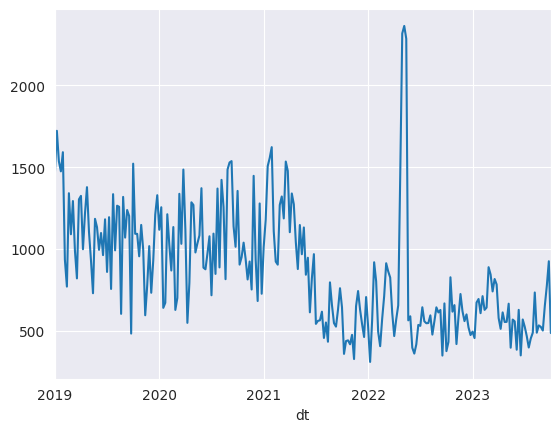

In [80]:
weather_weekly_df['RADIACAO GLOBAL (Kj/m²)'].plot()

<Axes: xlabel='dt'>

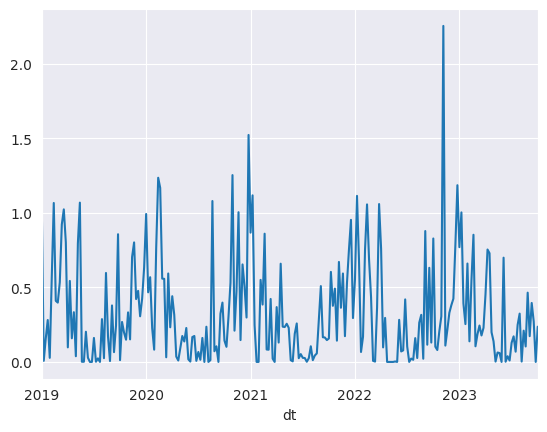

In [81]:
weather_weekly_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].plot()

Text(1.0, 0.75, '2021')

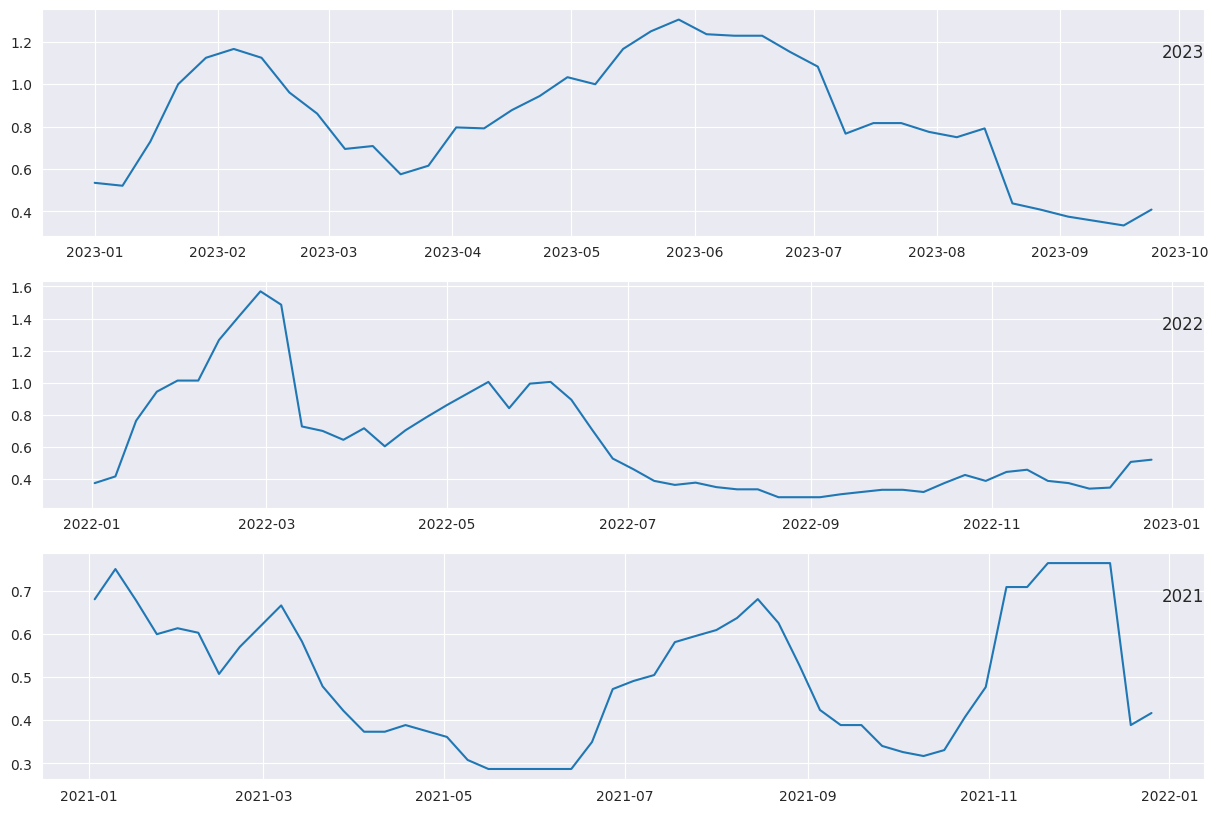

In [82]:
precos_2023 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2023-01-01')& (filtered_alface_crespa_roca.index < '2023-12-31')]

precos_2022 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2022-01-01')& (filtered_alface_crespa_roca.index < '2022-12-31')]


precos_2021 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2021-01-01')& (filtered_alface_crespa_roca.index < '2021-12-31')]

#.plot(title='Soma Preço unitário x Semana')
plt.figure(figsize=(15, 10))


plt.subplot(3, 1, 1)
plt.plot(precos_2023.Preco_unitario.resample('W').mean())
plt.title("2023", y=0.75, loc='right')

plt.subplot(3, 1, 2)
plt.plot(precos_2022.Preco_unitario.resample('W').mean())
plt.title("2022", y=0.75, loc='right')

plt.subplot(3, 1, 3)
plt.plot(precos_2021.Preco_unitario.resample('W').mean())
plt.title("2021", y=0.75, loc='right')

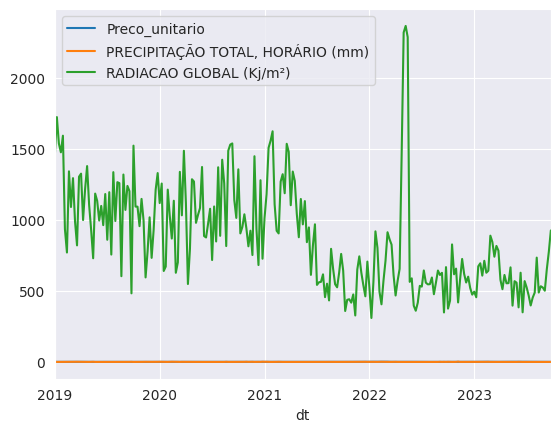

In [83]:
prices_after_2019 = filtered_alface_crespa_roca[filtered_alface_crespa_roca.index >= '2019-01-01']

price_weather_df = pd.merge(prices_after_2019, weather_weekly_df, on='week', how='left')
price_weather_df.index = prices_after_2019.index

price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].plot()

price_weather_numeric_df = price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']]


In [84]:
price_weather_df

,Preco_unitario,week,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",RADIACAO GLOBAL (Kj/m²)
dt,,,,
2019-01-06,0.421297,2019-w01,1.070833,1455.111765
2019-01-13,0.500000,2019-w02,0.007143,1722.688776
2019-01-20,0.462780,2019-w03,0.155952,1536.601042
2019-01-27,0.479440,2019-w04,0.280952,1474.675758
2019-02-03,0.614720,2019-w05,0.027381,1591.778571
...,...,...,...,...
2023-08-27,0.408330,2023-w34,0.464286,523.641667
2023-09-03,0.375000,2023-w35,0.172619,501.019048
2023-09-10,0.354170,2023-w36,0.395238,652.449405


In [85]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

<Axes: >

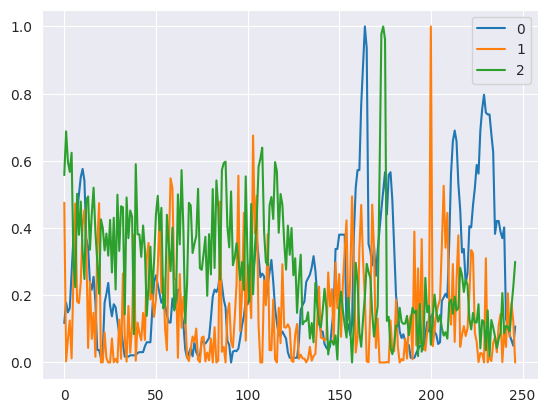